# Simple Convolutional Q8 Classification -- 3/31/2017
<pre>
In which I finally get a working accuracy metric.

Results:

1 conv layer: 30 epochs, lr=0.001, SGD, train acc (filtered): 35.6%, test acc (cb513): 31.6%
2 conv layer: 30 epochs, lr=0.001, SGD, train acc: 35.4%, test acc: 31.2% (???)
2 conv layer: 10 epochs, lr=0.01,  SGD, train acc: 3%, test acc: 3%

The model thinks it's smart by predicting 'H' for almost every residue (see bottom)
TODO: build a better model...
</pre>

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution1D
from keras import optimizers
from keras.regularizers import l2


import cullpdb_loader

Using TensorFlow backend.


## Constants and Hyperparameters

In [10]:
NUM_RESIDUES = 700  # per protein
RESIDUE_SIZE = 22   # size of one hot vector per residue
NUM_CLASSES = 9     # 8 + 'NoSeq'

FILTERS = 1    # Dimensions output by conv layer
                  # equivalently, size of output by each convolutional layer
WINDOW_SIZE = 11  # "scope" of convolution (ie 11 total residues)

TWO_D = True
if TWO_D:
    INPUT_SHAPE = (NUM_RESIDUES, RESIDUE_SIZE)  # see below
else:
    INPUT_SHAPE = (NUM_RESIDUES * RESIDUE_SIZE,)
OUTPUT_SIZE = NUM_CLASSES*NUM_RESIDUES      # output matrix holding predictions
#OUTPUT_SIZE = NUM_CLASSES

LEARNING_RATE = 0.001
GAMMA = 0  # momentum coefficient
EPOCHS = 30  # iterations of training, total dataset covered once each epoch
LOSS='categorical_crossentropy'
OPTIMIZER = optimizers.SGD(lr=LEARNING_RATE, momentum=GAMMA, nesterov=False)

SHOW_ACCURACY = True  # set to False for quicker train ops

SAVE_FILE = "models/dense-filtered-4-01"
DATA = "data/cullpdb+profile_6133.npy.gz"
DATA_FILTERED = "data/cullpdb+profile_6133_filtered.npy.gz"
DATA_TEST = "data/cb513+profile_split1.npy.gz"

## Load Data
<b>Data:</b><br> _x represents input proteins, _y represents target structure classifications (each as one-hot vectors) <br><br>
<b>Data Shape:</b><br> First dimension represents number of proteins, second number of residues per protein, and third size of residue or structure vector.<br> For example, train_x is shape (5600, 700, 22): it is an <b>m \* n \* p</b> matrix where there are <b>m</b> proteins (each row), <b>n</b> residues per protein (each column), and <b>p</b> sized vectors to represent a single residue or a single structure (each "slice").

In [3]:
train = cullpdb_loader.load_residues(DATA_FILTERED, split=False, two_d=TWO_D)  # load from my helper file

test = cullpdb_loader.load_cb513(DATA_TEST, two_d=TWO_D)

# train, validation, and test were loaded as tuples of (input, output);
# here we unpack them into separate variables:
train_x, train_y = train
#train_x, train_y = train_x[:2], train_y[:2]
#vali_x, vali_y = validation
test_x, test_y = test
#test_x, test_y = test_x[:20], test_y[:20]

cullpdb_loader.print_residues(train_x[0], labels=train_y[0], two_d=TWO_D)

train_y = train_y.reshape(len(train_y), NUM_CLASSES*NUM_RESIDUES)
test_y = test_y.reshape(len(test_y), NUM_CLASSES*NUM_RESIDUES)


# print to verify data was loaded in correct shapes:
print("train_x:", train_x.shape)
print("train_y", train_y.shape)
#print(vali_x.shape)
#print(vali_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Loading protein residues and labels...
Loading file from c:\SANJAY\CS\Projects\sdscbio\data\cullpdb+profile_6133_filtered.npy.gz...
File Loaded.
Loaded protein residues and labels.
Reshaping...
Reshaped
Loading file from c:\SANJAY\CS\Projects\sdscbio\data\cb513+profile_split1.npy.gz...
File Loaded.
Residues:
FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYTNRNNVVINFKVDESLCDNLYFKDTDQPLVPXPASYYTLASDRIAIPKGQIXAGVEVQLTDDFFADEKSISENYVIPLLXTNVQGADSILQGKPVVENPVLTNAGDWSILPQNFVLYAVKYVNPWHGEYLRRGIDHATVAGTSKDIIRHEQFVENDEVVNISTKSXKDNLLTLKTKDESGKDISYTVRLSFAEDGSCTVHSGSQNVVVSGSGKFVSKGEKNSLGGKDRNAIYLDYTVNLTDNNIQLATKDTLVLRTRNVYGGKSLEVVRK---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Custom Accuracy Metric (Test)

Currently, if inputs and outputs are both 2D (samples, protein length, num residues/classes) and the final layer of model is Reshape (from flattened to 2D), then Keras does not compute correct loss (wrong default axis maybe?). If inputs and outputs are both 1D (samples, length * residues), then Keras calculates loss correctly (sort of) but cannot compute accuracy (no notion of separate class one-hot vectors since they are all flattened).
<br><br>
Working fix: Omit Reshape layer, use default Keras loss, reshape labels to 1D, and define custom accuracy to reshape outputs to 2D before comparing to predicted labels.
<br><br>
TODO: Define custom Loss function to calculate correct loss on 2d inputs/outputs, use default accuracy, add Reshape layer to end of model, and don't have to reshape any inputs or labels manually.

In [4]:
# old metric - accuracy inflated with trailing 'NoSeq' equality
def custom_acc_old(obs, pred):
    # -1 = placeholder for whatever's left
    obs1 = K.reshape(obs, [-1, 700, 9])
    pred1 = K.reshape(pred, [-1, 700, 9])
    return K.mean(K.cast(
            K.equal(K.argmax(obs1, axis=2), K.argmax(pred1, axis=2)),
            dtype=K.floatx()))
    
# Second custom accuracy: ignore trailing noseq's
def custom_acc(true, obs):
    print("Using custom accuracy")
    if not SHOW_ACCURACY:
        return K.constant(float('NaN'))
    
    # -1 = placeholder for whatever's left
    obs = K.reshape(obs, [-1, 700, 9])
    true = K.reshape(true, [-1, 700, 9])
    
    # convert one-hot vectors for residues to scalars
    true_vals = K.argmax(true, axis=2)
    obs_vals = K.argmax(obs, axis=2)
    
    # mask is 2D matrix with 1s in indices that are residues
    # and 0s in indices that are 'NoSeq'
    # subtract all 8's to shift 'NoSeq' values to zero
    mask = K.sign(K.abs(true_vals - 8*K.ones_like(true_vals, dtype='int64')))
    mask = K.cast(mask, dtype=K.floatx())
    # 1D vector with each index the number of non-'NoSeq' residues 
    # in corresponding protein
    length = K.sum(mask, axis=1)
    
    # compare observed and predicted values (cast from boolean to 1s and 0s),
    # then multiply by mask to nullify any trailing 'NoSeq' equalities
    comparison = K.cast(K.equal(true_vals, obs_vals), dtype=K.floatx())
    comparison = comparison * mask
    
    # and return average
    return K.sum(comparison) / K.sum(length)
    

# not working
def custom_loss(obs, pred):
    pred = tf.Variable(pred)
    pred.set_shape([None, NUM_RESIDUES, NUM_CLASSES])
    obs = tf.Variable(obs)
    obs.set_shape([None, NUM_RESIDUES, NUM_CLASSES])
    return tf.nn.softmax_cross_entropy_with_logits(labels=pred, logits=obs, name='custom-loss')

## Model Architecture
The model is constructed to currently have 3 convolutional layers.<br><br>
A convolutional window "slides" across the input, each time taking the nearest <i>WINDOW_SIZE</i> number of features (residues) as inputs and outputing a single vector of dimension <i>FILTERS</i>.
<br><br>
This 3d data (samples, Protein Length, <i>FILTER_SIZE</i>) is flattened to 2d (samples, Length \* <i>FILTER_SIZE</i>). Finally a "dense", fully connected layer reduces the dimensionality of the data from the previous <i>FILTERS</i> dimensions to <i>OUTPUT_SIZE</i> dimensions (here 9, 8 for each secondary structure class and 1 for None).

In [11]:
model = Sequential()

# border_mode indicates how the convolution handles the edges of the input (where the window "sticks out").
# The 'same' setting pads the inputs with zeros on either side.
# Only the first layer requires an input_shape parameter; successive layers infer it from within the model.

# 1st layer
model.add(Convolution1D(
        FILTERS, WINDOW_SIZE, activation='tanh', border_mode='same', input_shape=INPUT_SHAPE))
# 2nd layer
model.add(Convolution1D(
        FILTERS, WINDOW_SIZE, activation='tanh', border_mode='same'))

model.add(Flatten())

# 'lecun_uniform' indicates that the weights should be initialized to small random values in a certain normal distribution.
model.add(Dense(OUTPUT_SIZE, init='lecun_uniform', name="OutputLayer", activation='softmax'))
#model.add(Reshape((NUM_RESIDUES, NUM_CLASSES)))

### Compile the model given a loss function, optimizer, and learning rate (specified above)

In [12]:
# optimizer= takes either string or optimizer object
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[custom_acc])

Using custom accuracy


### Train the model on training data against target training labels, show accuracy on validation data each epoch

In [13]:
# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
hist = model.fit(train_x, train_y, nb_epoch=EPOCHS, shuffle=False, verbose=2,
                 validation_data=(test_x, test_y))
print("Done training")

Train on 5534 samples, validate on 514 samples
Epoch 1/30
18s - loss: 5187.7910 - custom_acc: 0.1910 - val_loss: 5027.4035 - val_custom_acc: 0.2552
Epoch 2/30
19s - loss: 5061.9217 - custom_acc: 0.2596 - val_loss: 4972.4117 - val_custom_acc: 0.2838
Epoch 3/30
19s - loss: 5029.5167 - custom_acc: 0.2934 - val_loss: 4945.7162 - val_custom_acc: 0.2891
Epoch 4/30
19s - loss: 5010.4700 - custom_acc: 0.3097 - val_loss: 4931.1062 - val_custom_acc: 0.2899
Epoch 5/30
20s - loss: 4998.7691 - custom_acc: 0.3189 - val_loss: 4922.5865 - val_custom_acc: 0.2925
Epoch 6/30
20s - loss: 4990.7339 - custom_acc: 0.3250 - val_loss: 4916.5779 - val_custom_acc: 0.2952
Epoch 7/30
19s - loss: 4984.5881 - custom_acc: 0.3294 - val_loss: 4911.9522 - val_custom_acc: 0.2973
Epoch 8/30
19s - loss: 4979.6766 - custom_acc: 0.3326 - val_loss: 4908.2224 - val_custom_acc: 0.2992
Epoch 9/30
19s - loss: 4975.6937 - custom_acc: 0.3353 - val_loss: 4905.1455 - val_custom_acc: 0.3010
Epoch 10/30
19s - loss: 4972.3267 - custom_a

In [14]:
model.save(SAVE_FILE)

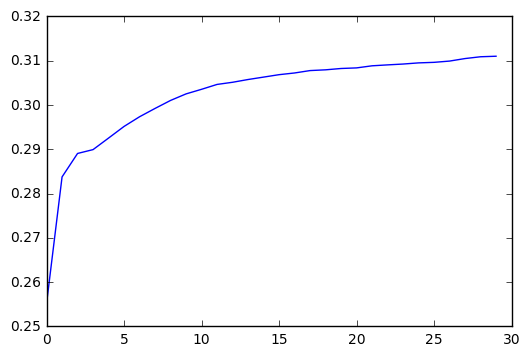

In [16]:
vali_loss = list(hist.history.values())[0]
plt.plot(range(EPOCHS), vali_loss)

## Test on cb513

In [17]:
test_acc = model.evaluate(test_x, test_y)
print(test_acc)

514/514 [==============================] - 0s     
[4883.5823808365758, 0.31101542554708772]


In [28]:
i = 4
prediction = model.predict(test_x[i:i+1])
print("Shape:", prediction.shape)

Shape: (1, 6300)


In [29]:
print("Expected:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=test_y[i], two_d=True)
print("\nPredicted:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=prediction[0], two_d=True)

Expected:

Residues:
TPAFNKPKVELHVHLDGAIKPETILYFGKKRGIALPADTVEELRNIIGMDKPLSLPGFLAKFDYYMPVIAGCREAIKRIAYEFVEMKAKEGVVYVEVRYSPHLLANSKVDPMPWNQTEGDVTPDDVVDLVNQGLQEGEQAFGIKVRSILCCMRHQPSWSLEVLELCKKYNQKTVVAMDLAGDETIEGSSLFPGHVEAYEGAVKNGIHRTVHAGEVGSPEVVREAVDILKTERVGHGYHTIEDEALYNRLLKENMHFEVCPWSSYLTGAWDPKTTHAVVRFKNDKANYSLNTDDPLIFKSTLDTDYQMTKKDMGFTEEEFKRLNINAAKSSFLPEEEKKELLERLYREYQ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Labels:
LLSLLSLEEEEEEEGGGSLLHHHHHHHHHHHTLLLSLSSHHHHHHHHSLSSLLLHHHHTTGGGGTHHHHTTLHHHHHHHHHHHHHHHHHTTEEEEEEEELSGGGLSSSLSSLGGGLLLLSLLHHHHHHHHHHHHHHHHHHHLLEEEEEEEEETTLTTTHHHHHHHHHHTBTTTEEEEEEESLTTSTTGGGLHHHHHHHHHHHHHTLEEEEEESSSSLHHHHHHHHHTTLLSEEEELGGGGGSHHHHHHHHHTTLEEEELHHHHHHTSSSL